<a href="https://colab.research.google.com/github/shilpathota/AI_ML/blob/master/Ragas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas langchain_community ragas sentence_transformers langchain langchain-text-splitters faiss-cpu langchain_groq langchain_together

In [2]:
# ragas_eval.py
import os
from typing import List, Dict
import pandas as pd

# ----- LangChain: docs → chunks → embeddings → FAISS retriever -----
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.document import Document
from langchain_community.embeddings import HuggingFaceEmbeddings

In [5]:

from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
os.environ["TOGETHER_API_KEY"] = userdata.get("TOGETHER_API_KEY")
# Choose an LLM to PRODUCE answers for the RAG system (you can swap)
USE_GROQ = bool(os.getenv("GROQ_API_KEY"))
USE_TOGETHER = bool(os.getenv("TOGETHER_API_KEY"))

if USE_GROQ:
    from langchain_groq import ChatGroq
elif USE_TOGETHER:
    from langchain_together import ChatTogether
else:
    # Fallback lightweight local model via transformers pipeline (very simple)
    from transformers import AutoModelForCausalLM, AutoTokenizer
    import torch

In [26]:

# ----- Ragas -----
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,        # Answer addresses the question?
    faithfulness,            # Claims supported by retrieved context
    context_precision,       # Retrieved chunks are useful for the answer
    context_recall,          # Retrieved chunks cover what was needed
    answer_correctness       # If you supply ground_truth answers
)
from ragas.dataset import Dataset
from sentence_transformers import SentenceTransformer
from ragas.run_config import RunConfig


In [7]:



# -------------------------------
# 1) Build toy corpus (replace with your own)
# -------------------------------
corpus = [
    "LangChain is a framework for developing applications powered by language models.",
    "FAISS is a library for efficient similarity search and clustering of dense vectors.",
    "Ragas is a library that provides evaluation metrics for Retrieval-Augmented Generation systems.",
    "SentenceTransformers provides easy-to-use sentence embeddings.",
]

docs = [Document(page_content=t) for t in corpus]


In [8]:

# -------------------------------
# 2) Chunk the docs
# -------------------------------
splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=30)
chunks: List[Document] = splitter.split_documents(docs)


In [9]:

# -------------------------------
# 3) Build embeddings + FAISS retriever (no API keys needed)
# -------------------------------
from google.colab import userdata
hf_token = userdata.get("HF_TOKEN")
emb_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = HuggingFaceEmbeddings(model_name=emb_model_name,model_kwargs={"use_auth_token": hf_token})
vectordb = FAISS.from_documents(chunks, embedder)
retriever = vectordb.as_retriever(search_kwargs={"k": 4})

/tmp/ipython-input-198452814.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name=emb_model_name,model_kwargs={"use_auth_token": hf_token})
/usr/local/lib/python3.12/dist-packages/sentence_transformers/SentenceTransformer.py:204: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(


In [14]:


# -------------------------------
# 4) Choose an LLM to answer user questions
# -------------------------------
def get_answer_llm():
    """
    Returns a LangChain ChatModel-like object with .invoke() support.
    You can switch among Groq, Together, or a tiny local HF model.
    """
    if USE_GROQ:
        # e.g., GROQ_API_KEY env var set
        return ChatGroq(model_name="llama-3.1-8b-instant", temperature=0.2)
    if USE_TOGETHER:
        # e.g., TOGETHER_API_KEY env var set
        return ChatTogether(model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", temperature=0.2)

    # Fallback: tiny local model (demo-quality only)
    model_id = "distilgpt2"
    tok = AutoTokenizer.from_pretrained(model_id)
    mdl = AutoModelForCausalLM.from_pretrained(model_id)
    mdl.eval()

    class TinyLocal:
        def invoke(self, messages, **kwargs):
            # messages is list[{"role": "user"/"system"/"assistant", "content": "..."}]
            prompt = messages[-1]["content"]
            input_ids = tok.encode(prompt, return_tensors="pt")
            with torch.no_grad():
                out = mdl.generate(input_ids, max_new_tokens=120, do_sample=False)
            text = tok.decode(out[0], skip_special_tokens=True)
            # Return last segment after the prompt
            text = text[len(prompt):].strip()
            return type("Resp", (), {"content": text})
    return TinyLocal()

answer_llm = get_answer_llm()

In [15]:


# -------------------------------
# 5) Define your evaluation set
#    (question, ground_truth answer)
# -------------------------------
eval_items = [
    {
        "question": "What is Ragas and what is it used for?",
        "ground_truth": "Ragas is a library for evaluating RAG systems, providing metrics like faithfulness, context precision and recall."
    },
    {
        "question": "What library can I use for dense vector similarity search?",
        "ground_truth": "FAISS is a library for efficient similarity search and clustering of dense vectors."
    },
    {
        "question": "How can I create sentence embeddings easily?",
        "ground_truth": "Use SentenceTransformers to get sentence embeddings easily."
    },
]

In [16]:


# -------------------------------
# 6) Run RAG for each question:
#    retrieve contexts → generate answer
# -------------------------------
def make_rag_answer(q: str) -> Dict:
    ctx_docs = retriever.invoke(q)
    context_texts = [d.page_content for d in ctx_docs]

    # Simple prompt template
    system = (
        "You are a helpful assistant. Use only the provided context when possible. "
        "If the context is insufficient, say you are unsure."
    )
    user = f"Question: {q}\n\nContext:\n" + "\n- ".join([""] + context_texts) + "\n\nAnswer clearly:"

    # LangChain ChatModels accept messages like below; TinyLocal wrapper also adheres
    resp = answer_llm.invoke([
        {"role": "system", "content": system},
        {"role": "user", "content": user},
    ])

    answer_text = getattr(resp, "content", str(resp))
    return {
        "question": q,
        "contexts": context_texts,
        "answer": answer_text,
    }

pred_rows = []
for item in eval_items:
    out = make_rag_answer(item["question"])
    out["ground_truth"] = item["ground_truth"]
    pred_rows.append(out)


In [18]:

# -------------------------------
# 7) Build a Ragas Dataset
# -------------------------------
from datasets import Dataset

dataset = Dataset.from_list(pred_rows)

In [19]:


# -------------------------------
# 8) Pick metrics (use as many as applicable)
# -------------------------------
metrics = [
    answer_relevancy,   # needs question + answer
    faithfulness,       # needs contexts + answer
    context_precision,  # needs contexts + question + answer
    context_recall,     # needs contexts + ground_truth + question
    answer_correctness  # needs ground_truth + answer
]


In [22]:

# -------------------------------
# 9) Provide LLM & Embeddings for Ragas itself
#    (judge-style checks + semantic bits)
#    - You can pass the same embedder
#    - For LLM, Ragas supports LangChain chat models OR OpenAI-compatible ones
# -------------------------------
# For embeddings inside evaluation (semantic comparisons):
ragas_embeddings = HuggingFaceEmbeddings(model_name=emb_model_name,model_kwargs={"use_auth_token": hf_token})


# For the evaluator LLM:
# - If you have Groq/Together keys, re-use `answer_llm`.
# - Otherwise, Ragas can work with local judge too, but large local judges are slower.
ragas_llm = answer_llm   # good enough for demo; you can use a different (stronger) judge model

/usr/local/lib/python3.12/dist-packages/sentence_transformers/SentenceTransformer.py:204: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(


In [27]:



# -------------------------------
# 10) Run evaluation
# -------------------------------
print("Running Ragas evaluation...")
run_cfg = RunConfig(
    timeout=120,      # per task
    max_retries=5,    # retry transient provider failures
    max_wait=30,      # backoff upper bound
    max_workers=2     # keep parallelism modest to avoid rate/timeouts
)

result = evaluate(
    dataset=dataset,
    metrics=metrics,
    llm=ragas_llm,            # the model configured with n=1 above
    embeddings=ragas_embeddings,
    run_config=run_cfg,
    raise_exceptions=False,   # keep going; failed rows get NaN
)


Running Ragas evaluation...


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
ERROR:ragas.executor:Exception raised in Job[10]: BadRequestError(Error code: 400 - {'error': {'message': "'n' : number must be at most 1", 'type': 'invalid_request_error'}})
ERROR:ragas.executor:Exception raised in Job[4]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jrrfz4a2erps800d1fa9e94j` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5537, Requested 1264. Please try again in 8.01s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}})


In [28]:

# -------------------------------
# 11) Show results (per-sample + aggregates)
# -------------------------------
df = result.to_pandas()           # per-row metric scores
agg = (
    df.select_dtypes(include=["number"])
      .mean(numeric_only=True)
      .to_frame(name="mean")
      .T
)
print("\n=== Per-sample scores ===")
print(df)

print("\n=== Aggregates (mean) ===")
print(agg)

# Optional: save for reporting
df.to_csv("ragas_per_sample.csv", index=False)
agg.to_csv("ragas_aggregate.csv", index=False)
print("\nSaved: ragas_per_sample.csv, ragas_aggregate.csv")




=== Per-sample scores ===
                                          user_input  \
0             What is Ragas and what is it used for?   
1  What library can I use for dense vector simila...   
2       How can I create sentence embeddings easily?   

                                  retrieved_contexts  \
0  [Ragas is a library that provides evaluation m...   
1  [FAISS is a library for efficient similarity s...   
2  [SentenceTransformers provides easy-to-use sen...   

                                            response  \
0  Ragas is a library that provides evaluation me...   
1  You can use FAISS for dense vector similarity ...   
2  To create sentence embeddings easily, you can ...   

                                           reference  answer_relevancy  \
0  Ragas is a library for evaluating RAG systems,...          0.982846   
1  FAISS is a library for efficient similarity se...               NaN   
2  Use SentenceTransformers to get sentence embed...               NaN   

 

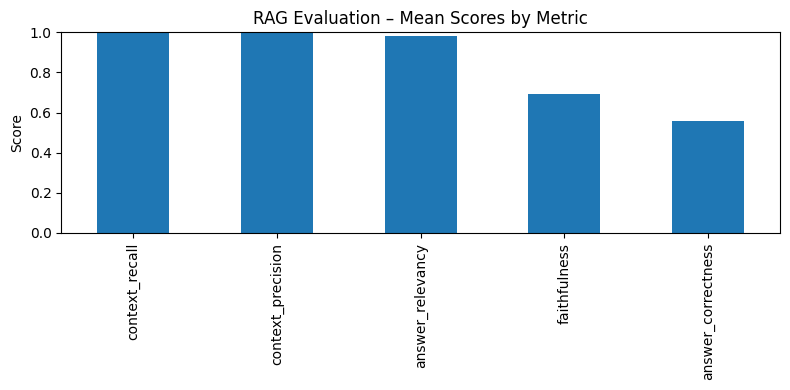

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# pick only numeric metric columns
metric_cols = df.select_dtypes(include=["number"]).columns

means = df[metric_cols].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
means.plot(kind="bar")
plt.title("RAG Evaluation – Mean Scores by Metric")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


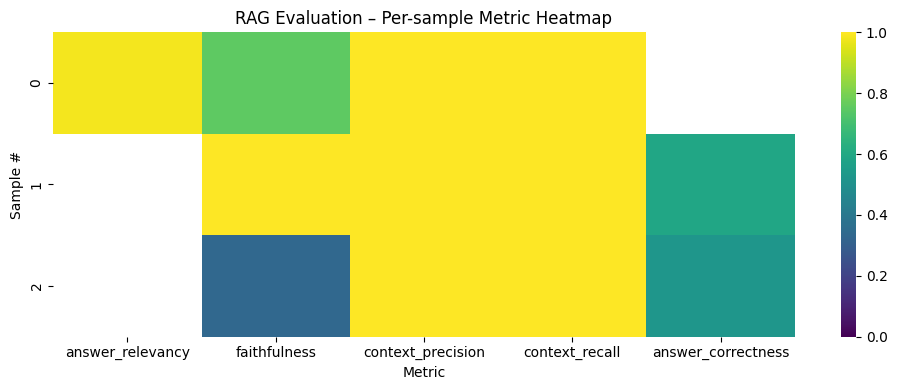

In [32]:
import seaborn as sns  # if you prefer pure matplotlib, see note below
import matplotlib.pyplot as plt

metric_cols = df.select_dtypes(include=["number"]).columns
heat = df[metric_cols]
plt.figure(figsize=(10, max(4, 0.35*len(df))))
sns.heatmap(heat, vmin=0, vmax=1, cmap="viridis", annot=False)
plt.title("RAG Evaluation – Per-sample Metric Heatmap")
plt.xlabel("Metric"); plt.ylabel("Sample #")
plt.tight_layout()
plt.show()


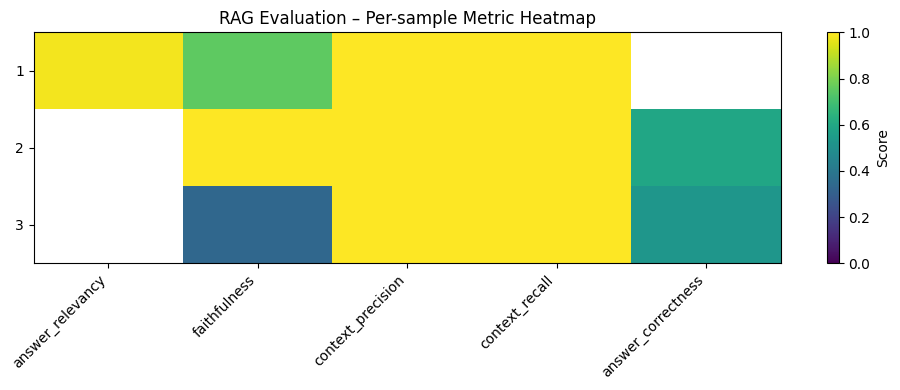

In [33]:
import numpy as np
import matplotlib.pyplot as plt

metric_cols = df.select_dtypes(include=["number"]).columns
mat = df[metric_cols].to_numpy()
plt.figure(figsize=(10, max(4, 0.35*len(df))))
plt.imshow(mat, aspect="auto", vmin=0, vmax=1)
plt.colorbar(label="Score")
plt.yticks(range(len(df)), range(1, len(df)+1))
plt.xticks(range(len(metric_cols)), metric_cols, rotation=45, ha="right")
plt.title("RAG Evaluation – Per-sample Metric Heatmap")
plt.tight_layout(); plt.show()


/tmp/ipython-input-3768874302.py:5: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



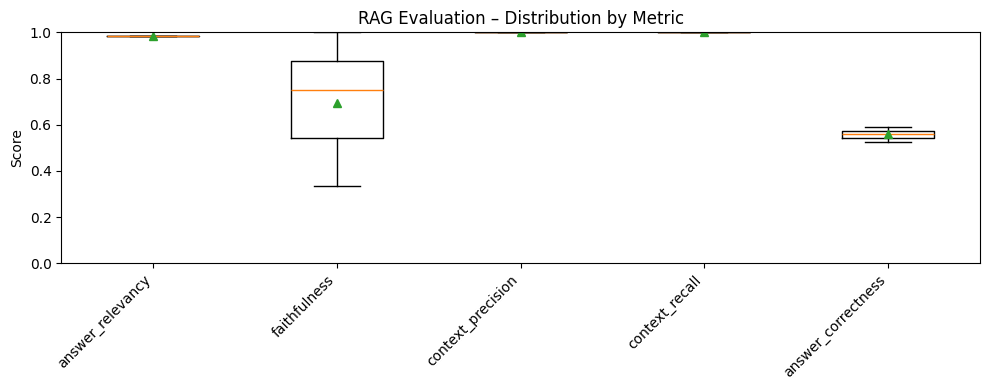

In [34]:
import matplotlib.pyplot as plt

metric_cols = df.select_dtypes(include=["number"]).columns
plt.figure(figsize=(10,4))
plt.boxplot([df[m].dropna() for m in metric_cols], labels=metric_cols, showmeans=True)
plt.title("RAG Evaluation – Distribution by Metric")
plt.ylabel("Score"); plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


In [36]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.4 MB/s eta 0:00:00
